# Julia Honours BCI Study
## Linear Mixed Effects analysis
### Classification precision

---
Copyright 2022 [Aaron J Newman](https://github.com/aaronjnewman), [NeuroCognitive Imaging Lab](http://ncil.science), [Dalhousie University](https://dal.ca)

Released under the [BSD 3-clause license](https://opensource.org/licenses/BSD-3-Clause)

---

## Load necessary libraries

In [6]:
library(tidyverse)
library(arrow)
library(ggplot2)
library(mgcv)
library(parallel)
library(emmeans)
library(sjPlot)
library(caret)
# library(stargazer)
library(yaml)
library(lme4)

Warning message:
“package ‘tidyverse’ was built under R version 4.1.3”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tibble’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.3”
Warning message:
“package ‘readr’ was built under R version 4.1.3”
Warning message:
“package ‘purrr’ was built under R version 4.1.3”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”
Warning message:
“package ‘stringr’ was built under R version 4.1.3”
Warning message:
“package ‘forcats’ was built under R version 4.1.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::l

## Set parameters for this analysis

In [7]:
cfg <- read_yaml('../../config.yml')

# num parallel processes for bam(). Should be less than the number of threads supported by your CPU
num_cores <- cfg$n_jobs

options("scipen"=100, "digits"=5)  # force decimal instead of scientific notation

## File paths

In [8]:
bids_root = '../..'
csv_path <- file.path(bids_root, 'derivatives', 'erp_classification_test_20_pct', 'tables')
# input_path <- paste(bids_root, '/derivatives/erp_classification/tables/classification_accuracy_results.csv', sep='')

# erp_path <- file.path(bids_root, 'derivatives', 'erp_indiv_subject_analysis', 'data')
# # behav_path <- file.path(bids_root, 'derivatives', 'behavioral_demographic', 'data')
# raw_path <- file.path(bids_root, 'rawdata')
out_path <- file.path(bids_root, 'derivatives', 'lda_lme')

# create output directories and any higher-level directories they are nested in, if they don't exist
tab_path <- file.path(out_path, 'tables')
dir.create(file.path(tab_path), recursive = TRUE, showWarnings = FALSE)

fig_path <- file.path(out_path, 'figures')
dir.create(file.path(fig_path), recursive = TRUE, showWarnings = FALSE)

## Set options for plots

In [9]:
set_theme(base = theme_sjplot(),
          title.size = 1.5,
          title.align = 'center',
          axis.title.size = 1.5,
          axis.textsize.x=1.1,
          axis.textsize.y=1.1,
          legend.title.size = 1.5,
          legend.item.size = 1.25,
          legend.item.backcol = 'white',
          legend.size = 1.5,
          panel.gridcol.x='white',
          panel.minor.gridcol='white'
         )

---
## Load Classifier Results

In [10]:
# load in the csv, split the Condition column and create new columns for Colour, Orientation, and Type
dat <- read_csv(file.path(csv_path, "classification_accuracy_results.csv"), show_col_types = FALSE) %>%
        separate(Condition, into = c('Emotion', 'Colour'), sep = "/") %>%
        #Filter(Condition %in% c('Angry/Grey','Angry/Red','Neutral/Grey','Neutral/Red') 
        #Filter(Colour %in% c('Red', 'Grey')) %>%
        mutate_if(is.character, as.factor) %>%
        droplevels()

summary(dat)


 participant_id    Emotion     Colour    Classifier  CV_accuracy  
 sub-001: 12    Angry  :186   Grey:186   LDA:124    Min.   :80.7  
 sub-002: 12    Neutral:186   Red :186   LR :124    1st Qu.:91.0  
 sub-003: 12                             SVM:124    Median :93.9  
 sub-004: 12                                        Mean   :93.1  
 sub-005: 12                                        3rd Qu.:96.1  
 sub-006: 12                                        Max.   :99.2  
 (Other):300                                                      
 Test_accuracy    CV_precision   Test_precision    CV_recall    
 Min.   : 78.6   Min.   : 44.3   Min.   : 40.0   Min.   : 43.5  
 1st Qu.: 91.2   1st Qu.: 72.2   1st Qu.: 71.3   1st Qu.: 73.4  
 Median : 94.4   Median : 81.1   Median : 82.5   Median : 82.5  
 Mean   : 93.5   Mean   : 79.9   Mean   : 80.4   Mean   : 80.8  
 3rd Qu.: 96.1   3rd Qu.: 89.2   3rd Qu.: 90.3   3rd Qu.: 89.2  
 Max.   :100.0   Max.   :100.0   Max.   :100.0   Max.   :100.0  
         

## Run LME model using logistic regression classifier, and visualize

In [11]:
#GLM regression analysis on dat 
# mod_lmer <- lmer(Test_precision ~ Emotion * Colour * Classifier + (1|participant_id), data = dat)


# summary(mod_lmer)

In [12]:
dat_lr <- dat[dat$Classifier=='LR',]

cl <- makeCluster(num_cores)  

mod_lr <- bam(Test_precision ~ Emotion * Colour
                  + s(participant_id, bs="re"),
#                   + s(Channel, participant_id, bs="re"), 
                  data=dat_lr,
                  samfrac=0.1, cluster=cl, gc.level=2)

stopCluster(cl)

In [13]:
summary(mod_lr) 


Family: gaussian 
Link function: identity 

Formula:
Test_precision ~ Emotion * Colour + s(participant_id, bs = "re")

Parametric coefficients:
                         Estimate Std. Error t value            Pr(>|t|)    
(Intercept)                86.626      1.883   46.01 <0.0000000000000002 ***
EmotionNeutral             -0.439      1.969   -0.22                0.82    
ColourRed                   1.416      1.969    0.72                0.47    
EmotionNeutral:ColourRed    0.961      2.785    0.35                0.73    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                  edf Ref.df    F             p-value    
s(participant_id)  23     30 3.31 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.444   Deviance explained = 56.2%
fREML = 444.82  Scale est. = 60.091    n = 124


Method: fREML   Optimizer: perf newton
full convergence after 7 iterations.
Gradient range [-0.0000000000059472,0.000000000001215]
(score 444.82 & scale 60.091).
Hessian positive definite, eigenvalue range [6.3756,62.476].
Model rank =  35 / 35 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                  k' edf k-index p-value
s(participant_id) 31  23      NA      NA


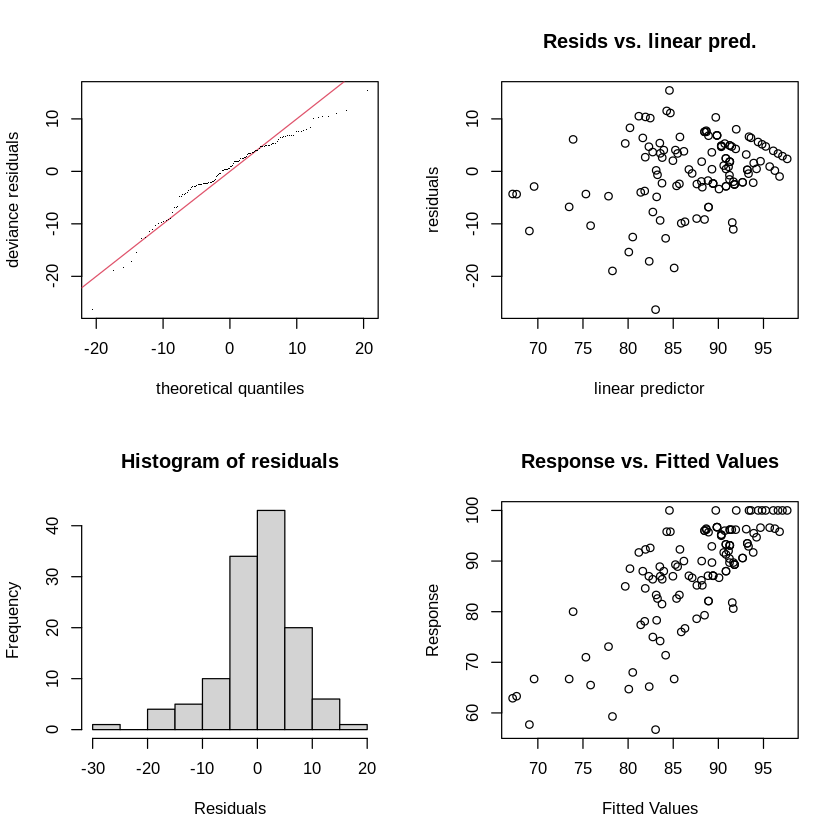

In [14]:
gam.check(mod_lr)

png 
  2

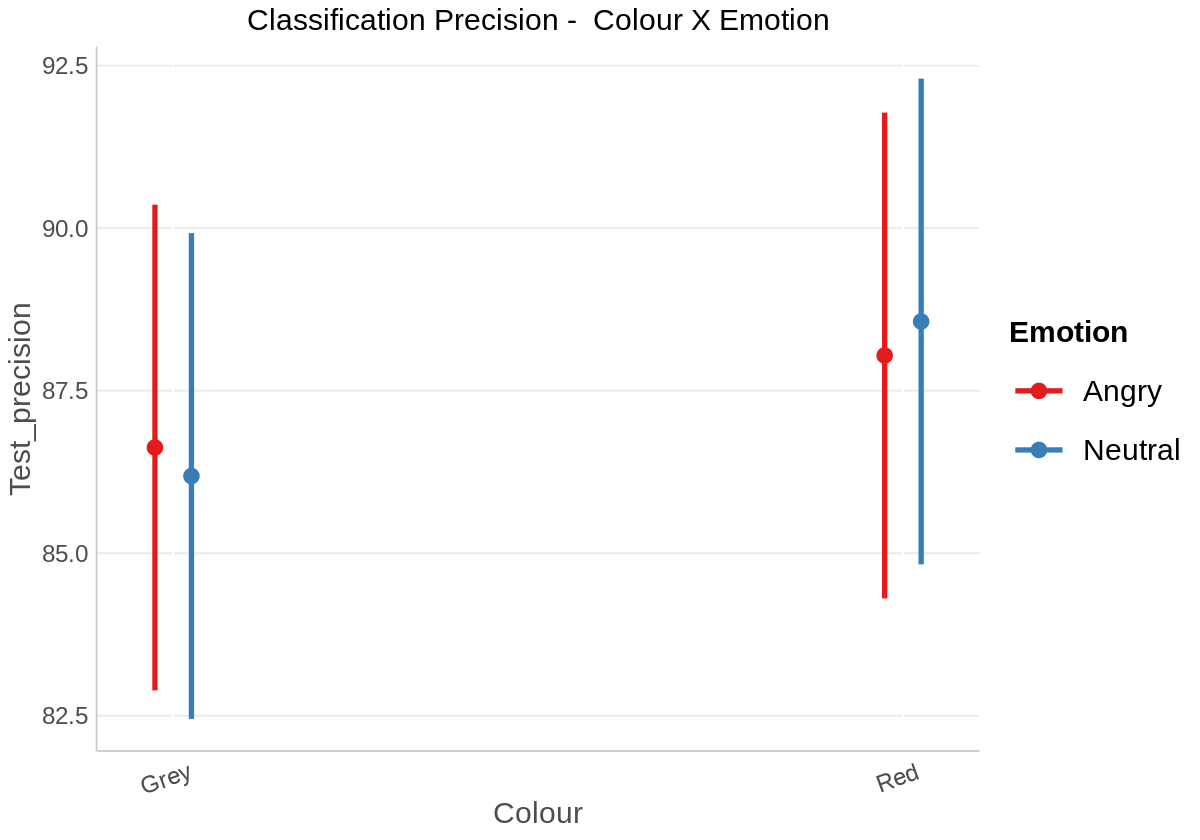

In [15]:
terms <- c('Colour', 'Emotion')
out_stem <- paste(fig_path, '/', '_lme_classification_', paste(terms, collapse='_X_'), '.pdf', sep='')

options(repr.plot.width=10) #, repr.plot.height=5)

pm <- function(mod, terms) {
                plot_model(mod, type='emm', terms=terms,
                 title=paste('Classification Precision - ', paste(terms, collapse=' X ')),
                 dot.size=4, line.size=1.5) +
                 theme(axis.text.x = element_text(angle = 20, hjust = .67, vjust=.67))
    }

pdf(out_stem)
pm(mod_lr, terms)
dev.off() 
pm(mod_lr, terms)          

## Statistical results

In [16]:
terms <- c('Colour', 'Emotion')
out_stem <- paste(tab_path, '/', paste(terms, collapse='_X_', sep=''), sep='')

Contrasts.emm <- emmeans(mod_cl, pairwise ~ Emotion * Colour)
contr_tab <- as.data.frame(Contrasts.emm$contrasts)
# contr_tab

eff_tab <- eff_size(Contrasts.emm,
                     sigma = sigma(mod_full), 
                     edf = contr_tab$df[1])
eff_tab <- as.data.frame(eff_tab)
eff_tab$contrast <- gsub('\\(','',as.character(eff_tab$contrast))
eff_tab$contrast <- gsub('\\)','',as.character(eff_tab$contrast))
# eff_tab

full_tab <- contr_tab %>% full_join(select(eff_tab,'contrast', 'effect.size',  'lower.CL', 'upper.CL'),
                                    by=c('contrast'), 
                                    suffix = c(".ctr", ".eff"))  %>% 
                            mutate(across(c('p.value', 'effect.size'), round, 3)) %>% 
                            mutate(across(c('estimate', 'SE', 't.ratio'), round, 2)) %>% 
                            mutate(across(c('lower.CL', 'upper.CL'), round, 3)) %>% 
                            rename('Estimate (µV)' = 'estimate',
                                    't' = 't.ratio',
                                    'p' = 'p.value',
                                    'Effect Size' = 'effect.size',
                                    'CL low' = 'lower.CL',
                                    'CL high' = 'upper.CL'
                            ) %>% 
                            select('contrast','Estimate (µV)', 'SE', 
                            'Effect Size', 'CL low', 'CL high', 't', 'p')  

full_tab

# Write table to CSV
write.csv(full_tab, 
          file=paste(out_stem, '.csv', sep=''),
          row.names=FALSE
         )

## Write table to LaTeX
# tmp <- capture.output(stargazer(full_tab, 
#                                 summary=FALSE, rownames=FALSE,
#                                 label=paste('tab:', component, '_lme_', paste(terms, collapse='_X_'), '_LvsR', sep=''),
#                                 title='Between-hemisphere contrasts for each condition, from the linear mixed effects analysis. All p values are corrected for multiple comparisons using Tukey\'s method'
#                                ),
#                       file=paste(out_stem, '.tex', sep='')
#                      )

ERROR: Error in .chk.list(object, ...): object 'mod_cl' not found


## Compare classifiers

In [ ]:
cl <- makeCluster(num_cores)  

mod_cl <- bam(Test_precision ~ Emotion * Colour * Classifier
                  + s(participant_id, bs="re"),
#                   + s(Classifier, participant_id, bs="re"), 
                  data=dat,
                  samfrac=0.1, cluster=cl, gc.level=2)

stopCluster(cl)

In [ ]:
terms <- c('Colour', 'Classifier', 'Emotion')
out_stem <- paste(fig_path, '/', '_lme_classification_', paste(terms, collapse='_X_'), '.pdf', sep='')

options(repr.plot.width=10) #, repr.plot.height=5)

pm <- function(mod, terms) {
                plot_model(mod, type='emm', terms=terms,
                 title=paste('Classification Precision - ', paste(terms, collapse=' X ')),
                 dot.size=4, line.size=1.5) +
                 theme(axis.text.x = element_text(angle = 20, hjust = .67, vjust=.67))
    }

pdf(out_stem)
pm(mod_cl, terms)
dev.off() 
pm(mod_cl, terms)          

## Compare classifiers - statistical values
### Collapsed across emotion & colour conditions

In [ ]:
terms <- c('Classifier')
out_stem <- paste(tab_path, '/classifier_comparison', sep='')

Contrasts.emm <- emmeans(mod_cl, pairwise ~ Classifier)
contr_tab <- as.data.frame(Contrasts.emm$contrasts)
# contr_tab

eff_tab <- eff_size(Contrasts.emm,
                     sigma = sigma(mod_full), 
                     edf = contr_tab$df[1])
eff_tab <- as.data.frame(eff_tab) 
eff_tab$contrast <- gsub('\\(','',as.character(eff_tab$contrast))
eff_tab$contrast <- gsub('\\)','',as.character(eff_tab$contrast))
# eff_tab

full_tab <- contr_tab %>% full_join(select(eff_tab, 'contrast', 'effect.size',  'lower.CL', 'upper.CL'),
                                    by=c('contrast'), 
                                    suffix = c(".ctr", ".eff"))  %>% 
                            mutate(across(c('p.value', 'effect.size'), round, 3)) %>% 
                            mutate(across(c('estimate', 'SE', 't.ratio'), round, 2)) %>% 
                            mutate(across(c('lower.CL', 'upper.CL'), round, 3)) %>% 
                            rename('Estimate (µV)' = 'estimate',
                                    't' = 't.ratio',
                                    'p' = 'p.value',
                                    'Effect Size' = 'effect.size',
                                    'CL low' = 'lower.CL',
                                    'CL high' = 'upper.CL'
                            ) %>% 
                            select('contrast','Estimate (µV)', 'SE', 
                            'Effect Size', 'CL low', 'CL high', 't', 'p')  

full_tab

# Write table to CSV
write.csv(full_tab, 
          file=paste(out_stem, '.csv', sep=''),
          row.names=FALSE
         )

## Write table to LaTeX
# tmp <- capture.output(stargazer(full_tab, 
#                                 summary=FALSE, rownames=FALSE,
#                                 label=paste('tab:', component, '_lme_', paste(terms, collapse='_X_'), '_LvsR', sep=''),
#                                 title='Between-hemisphere contrasts for each condition, from the linear mixed effects analysis. All p values are corrected for multiple comparisons using Tukey\'s method'
#                                ),
#                       file=paste(out_stem, '.tex', sep='')
#                      )